In [2]:
import os, sys
import json
import tweepy
import tarfile
import shutil

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

import time
from time import mktime
import datetime

In [42]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib inline
import matplotlib.font_manager as fm
fm.findSystemFonts()
font = {"family":"IPAexGothic"}
mpl.rc('font', **font)

In [3]:
# NLR

import MeCab
mecab = MeCab.Tagger (r"-Ochasen -d C:\Users\myaun\Downloads\ipadic-neologd")

import re
import unicodedata
import neologdn

from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

from gensim import corpora, models

C:\Users\myaun\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [62]:
# normarize

def clean_text(text):
    #replaced_text = '\n'.join(s.strip() for s in text.splitlines()[2:] if s != '')  # skip header by [2:]
    replaced_text = text.lower()
    replaced_text = re.sub(r'[【】]', ' ', replaced_text)       # 【】の除去
    replaced_text = re.sub(r'[（）()]', ' ', replaced_text)     # （）の除去
    replaced_text = re.sub(r'[［］\[\]]', ' ', replaced_text)   # ［］の除去
    replaced_text = re.sub(r'[@＠]\w+', '', replaced_text)  # メンションの除去
    #replaced_text = re.sub(r'https?:\/\/.*?[\r\n ]', '', replaced_text)  # URLの除去
    replaced_text=re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-…]+', "", replaced_text)
    replaced_text = re.sub(r'　', ' ', replaced_text)  # 全角空白の除去
    for rmword in ['w', 'W', 'ｗ', 'Ｗ', '笑']:
        replaced_text = replaced_text.replace(rmword, '')
    return replaced_text

def normalize_number(text):
    replaced_text = re.sub(r'\d+', '0', text)
    return replaced_text

def normalize_text( text ):
    text = clean_text(text)
    text = unicodedata.normalize('NFC', text)
    text = neologdn.normalize(text)
    # text = normalize_number(text)    
    return text

def remove_stopwords( tokens ):
    filtered = []
    for w in tokens:
        if w not in stopWords:
            filtered.append(w)
    return filtered

# tokenize

def get_tokens( text ):
    tokens = []
    result = mecab.parseToNode( text )
    while result:
        pos = result.feature.split(',')[0]
        token.append( result.surface )
        result = result.next
    tokens = remove_stopwords( tokens )
    return tokens

def get_tokens_pos( text, target_pos ):
    nouns = []
    result = mecab.parseToNode( text )
    while result:
        pos = result.feature.split(',')[0]
        if pos in target_pos:
            nouns.append( result.surface )
        result = result.next
    tokens = remove_stopwords( nouns )
    return tokens

def get_nouns( text ):
    nouns = []
    result = mecab.parseToNode( text )
    while result:
        pos = result.feature.split(',')[0]
        if pos == '名詞': nouns.append( result.surface )
        result = result.next
    tokens = remove_stopwords( nouns )
    return tokens

def get_entity( text ):
    entity = []
    result = mecab.parseToNode( text )
    while result:
        line = result.feature.split(',')
        pos, tag = line[0], line[1]
        if tag == '固有名詞': entity.append( result.surface )
        result = result.next
    tokens = remove_stopwords( entity )
    return tokens

In [22]:
def load_tweets( query ):
    savepath =  "./data/tweet"
    query_dir = "%s/%s" % (savepath, query)
    if not os.path.exists( query_dir ):
        os.mkdir(query_dir)

    rows = []
    files = os.listdir(query_dir)
    for idx, file in enumerate(files):
        if os.path.isfile( "%s/%s" % (query_dir, file) ): # file
            taffile_path = "%s/%s" % (query_dir, file)
            tf = tarfile.open( taffile_path , 'r')
            for fname_in_tar in tf.getnames():
                f = tf.extractfile( fname_in_tar )
                tweet = json.loads( f.read().decode() )
                struct = time.strptime(tweet['created_at'],'%a %b %d %H:%M:%S +0000 %Y')
                dt = datetime.datetime.fromtimestamp(mktime(struct))
                dt_diff = dt + datetime.timedelta(hours=9)
                rows.append( [dt_diff, tweet['id'], tweet['text']] )  
        else: # dir
            target_dir = "%s/%s" % (query_dir, file)
            files = os.listdir(target_dir)
            for idx, file in enumerate(files):
                f = open('%s/%s' % (target_dir, file), 'r')
                tweet = json.load(f)
                f.close()

                struct = time.strptime(tweet['created_at'],'%a %b %d %H:%M:%S +0000 %Y')
                dt = datetime.datetime.fromtimestamp(mktime(struct))
                dt_diff = dt + datetime.timedelta(hours=9)
                rows.append( [dt_diff, tweet['id'], tweet['text']] )
    return rows

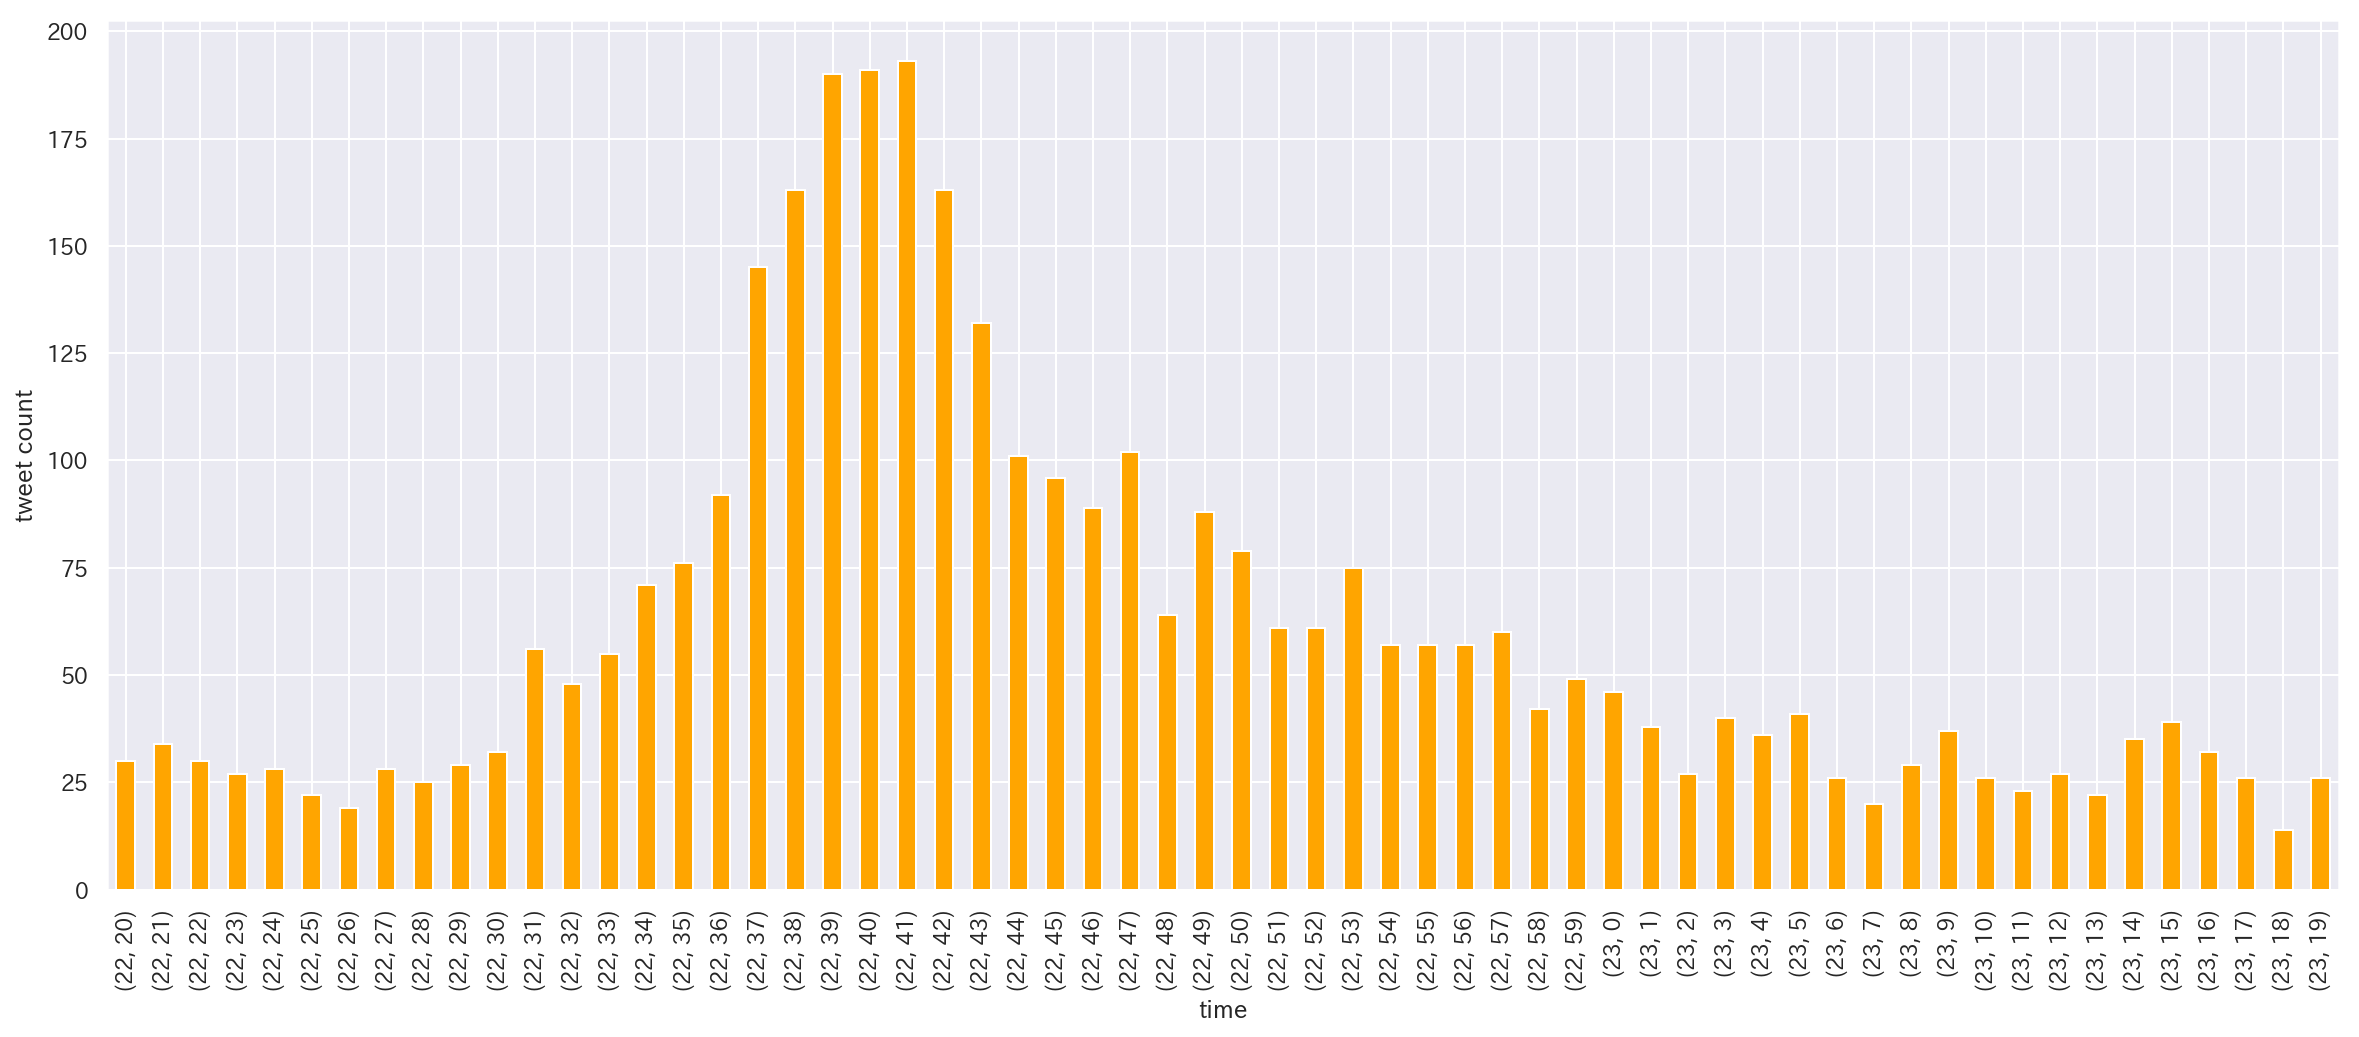

In [88]:
query = "#欅坂46"
rows = load_tweets( query )
df_sol = pd.DataFrame( rows, columns=['created_at', 'id', 'text'] )
onair_time = ['2019-01-21 22:20', '2019-01-21 23:20']
df_onair = df_sol.query('created_at > "%s" and created_at < "%s"' % (onair_time[0], onair_time[1]))

df_onair['created_at'].groupby([df_onair["created_at"].dt.hour, df_onair["created_at"].dt.minute]).count().plot(
    x='time', kind="bar", color="orange", figsize=(20, 8))
plt.xlabel("time", fontdict={'size': 12})
plt.ylabel("tweet count", fontdict={'size': 12})
plt.show()

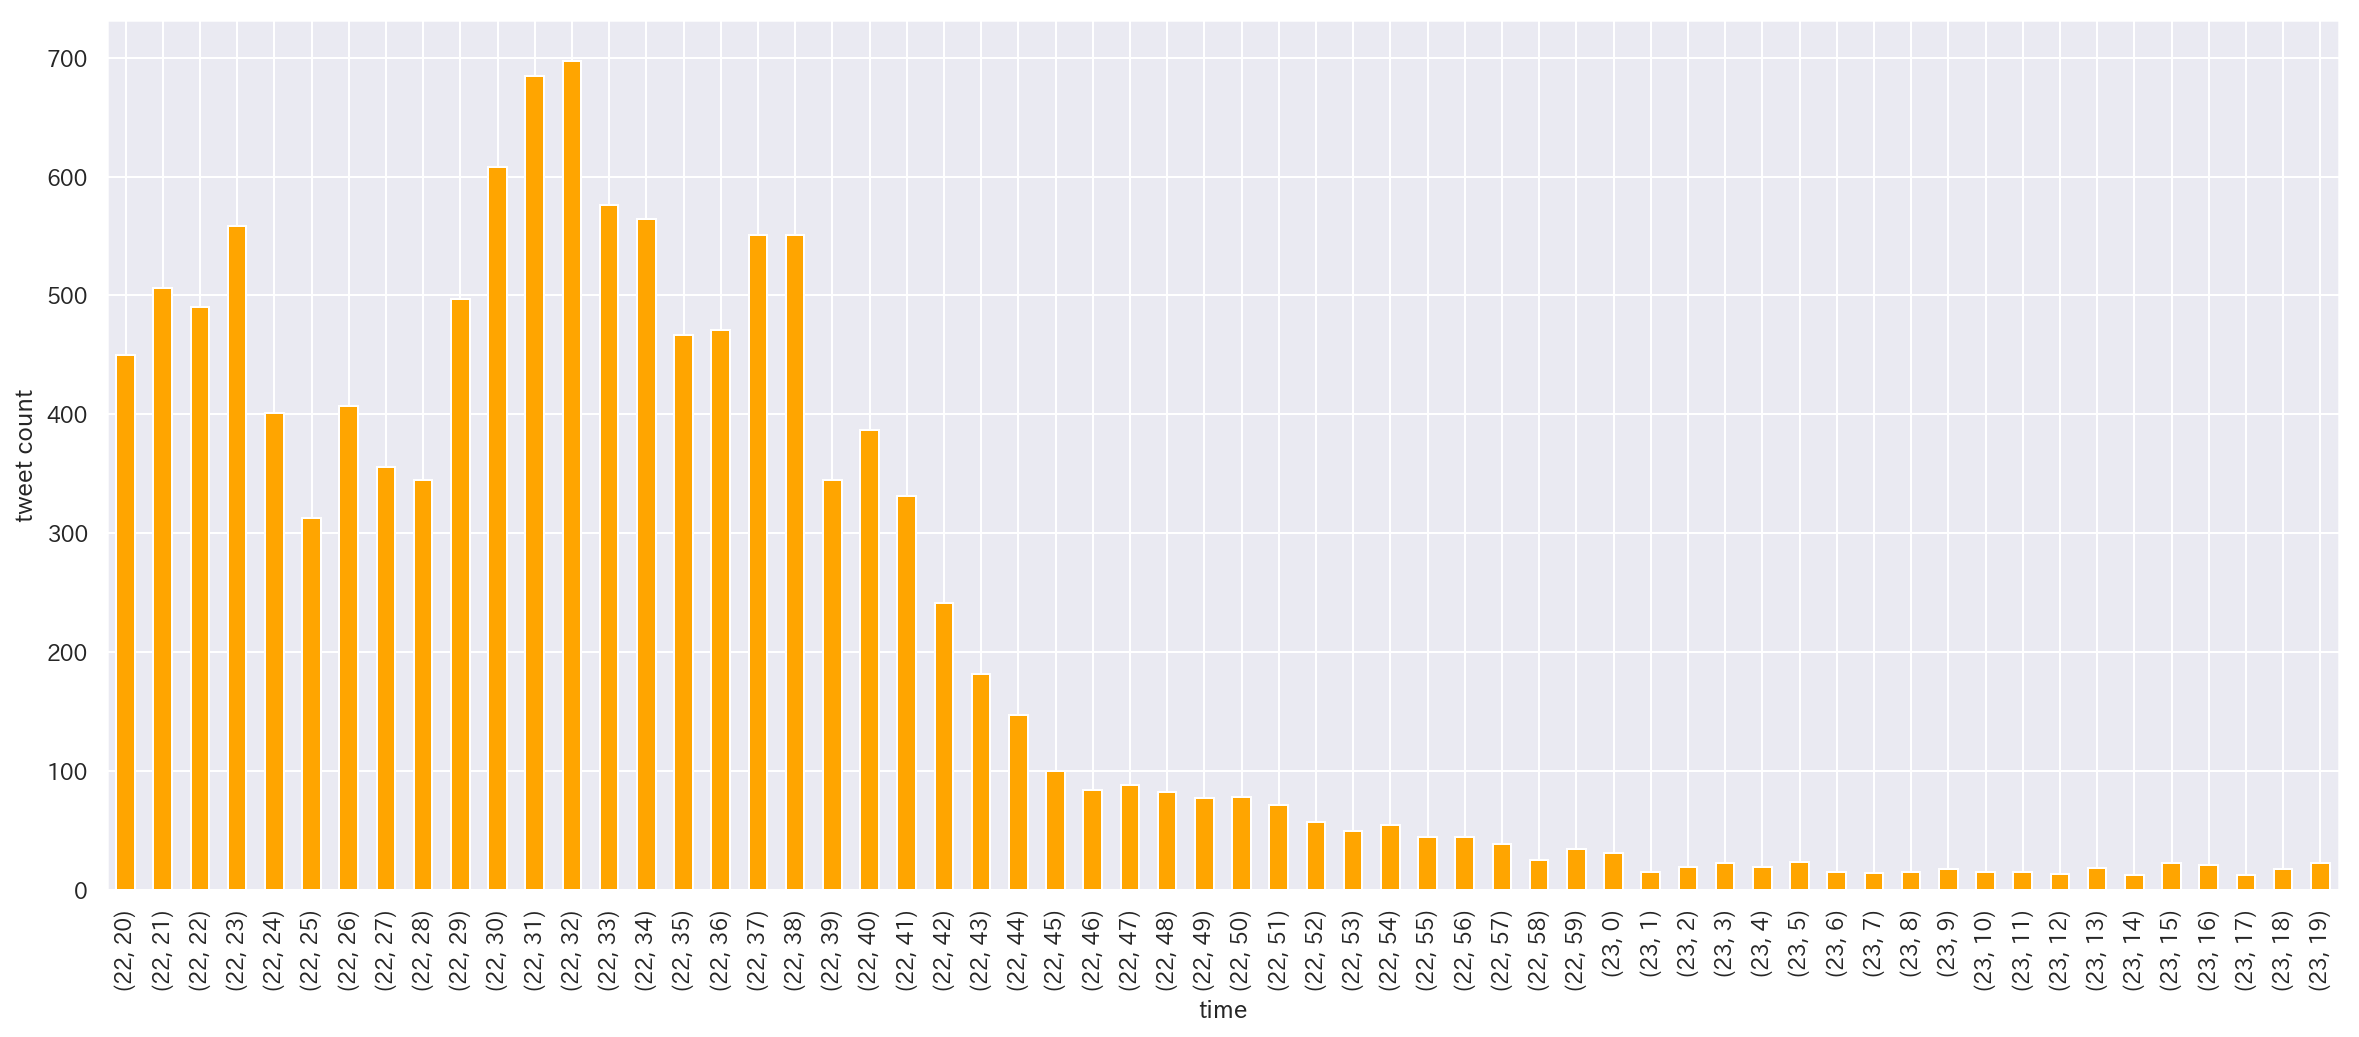

In [86]:
query = "#SOL"
rows = load_tweets( query )
df_sol = pd.DataFrame( rows, columns=['created_at', 'id', 'text'] )
onair_time = ['2019-01-21 22:20', '2019-01-21 23:20']
df_onair = df_sol.query('created_at > "%s" and created_at < "%s"' % (onair_time[0], onair_time[1]))

df_onair['created_at'].groupby([df_onair["created_at"].dt.hour, df_onair["created_at"].dt.minute]).count().plot(
    x='time', kind="bar", color="orange", figsize=(20, 8))
plt.xlabel("time", fontdict={'size': 12})
plt.ylabel("tweet count", fontdict={'size': 12})
plt.show()

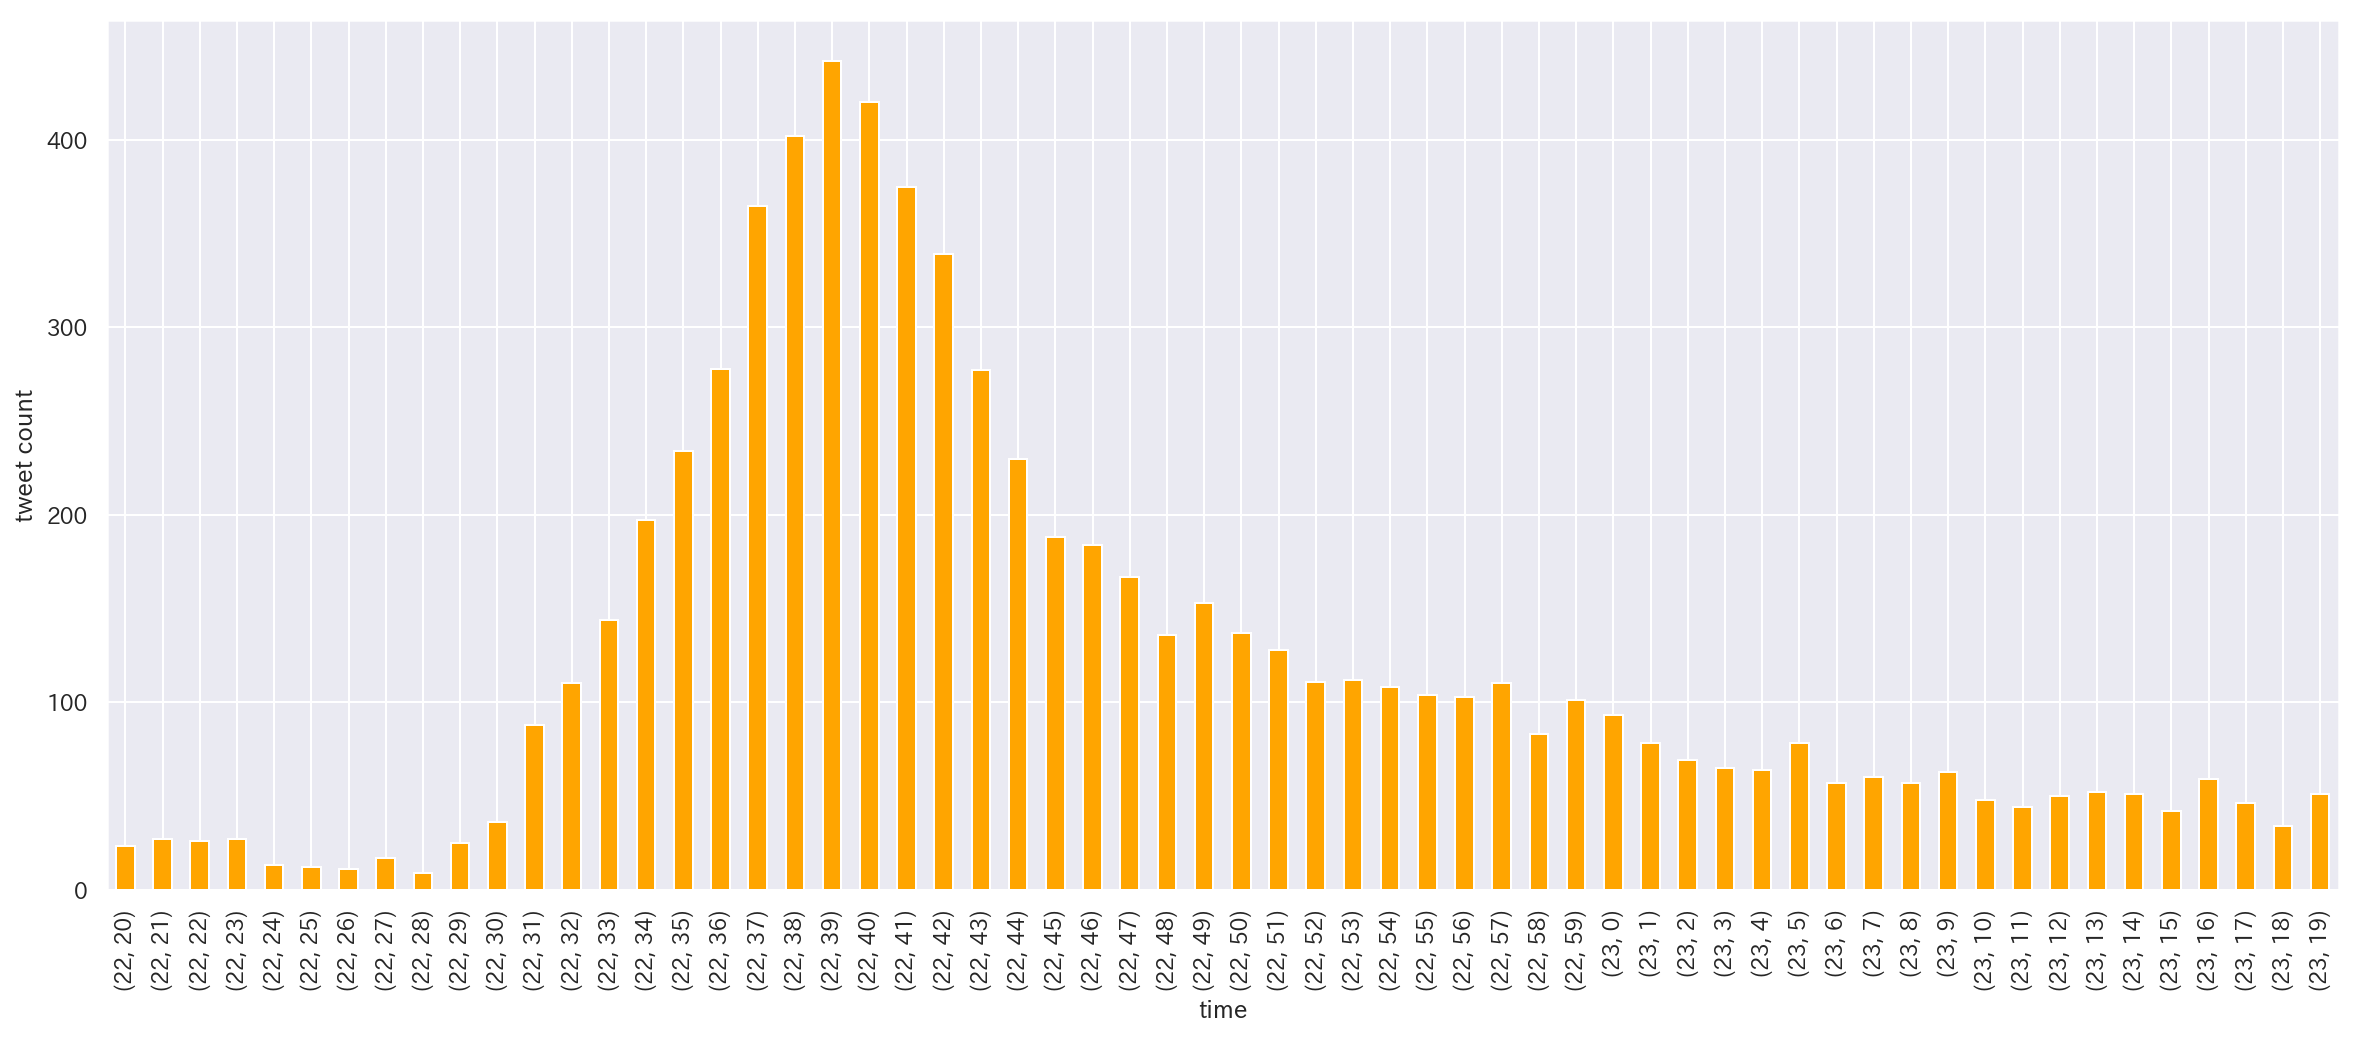

In [87]:
query = "#黒い羊"
rows = load_tweets( query )
df = pd.DataFrame( rows, columns=['created_at', 'id', 'text'] )
onair_time = ['2019-01-21 22:20', '2019-01-21 23:20']
df_onair = df.query('created_at > "%s" and created_at < "%s"' % (onair_time[0], onair_time[1]))

df_onair['created_at'].groupby([df_onair["created_at"].dt.hour, df_onair["created_at"].dt.minute]).count().plot(
    x='time', kind="bar", color="orange", figsize=(20, 8))
plt.xlabel("time", fontdict={'size': 12})
plt.ylabel("tweet count", fontdict={'size': 12})
plt.show()

In [105]:
query = "#黒い羊"
rows = load_tweets( query )
df_sol = pd.DataFrame( rows, columns=['created_at', 'id', 'text'] )
onair_time = ['2019-01-21 22:20', '2019-01-21 23:20']
df_onair = df_sol.query('created_at > "%s" and created_at < "%s"' % (onair_time[0], onair_time[1]))
grouped = df_onair.groupby([df["created_at"].dt.hour, df["created_at"].dt.minute])
for idx, key in enumerate( grouped.groups.keys()):
    texts = grouped.get_group(key)['text'].values.tolist()
    BoE = [ get_entity( normalize_text( text ) ) for text in texts ]
    dictionary = corpora.Dictionary( BoE )
    top10 = [ dictionary[i] for i, j in sorted( dictionary.dfs.items(), key=lambda x:x[1], reverse=True)[:10] ]
    print( '%2d時%2d分  tweet_num:%d　-> keywords:' % (key[0], key[1], len(texts)), top10 )

22時20分  tweet_num:23　-> keywords: ['sol', '欅坂46', '平手友梨奈', 'スクールオブロック', 'てち', 'もうすぐだ', '平手', '友梨奈', 'イヤホン', '8t']
22時21分  tweet_num:27　-> keywords: ['sol', '平手友梨奈', '欅坂46', 'てち', 'パルコ', 'girls', '甘噛み', 'あけおめ', 'oa', '欅坂']
22時22分  tweet_num:26　-> keywords: ['sol', '欅坂46', '平手友梨奈', 'てち', 'school of lock!', '今日だけは', 'ok', 'カミカミ', 'ジングル', '好きな人']
22時23分  tweet_num:27　-> keywords: ['sol', '平手友梨奈', '欅坂46', 'てち', 'パルコ', 'school of lock!', 'schooloflock', 'ゆりな', 'スクールオブロック', '平手']
22時24分  tweet_num:13　-> keywords: ['sol', '欅坂46', '平手友梨奈', 'てち', '平手', 'きたあ', 'ガールズ', '共喰い', 'パルコ', '好きな人']
22時25分  tweet_num:12　-> keywords: ['sol', '平手友梨奈', '欅坂46', 'てち', 'schooloflock', 'マジで', '立ち位置', '3列目', 'もん', '???']
22時26分  tweet_num:11　-> keywords: ['sol', '平手友梨奈', '欅坂46', 'てち', 'キャロ', 'ふー', '好きな人', '3週目', 'schooloflock', 'まーす']
22時27分  tweet_num:17　-> keywords: ['sol', '平手友梨奈', '欅坂46', 'てち', 'school of lock!', 'バンジー', 'けやかけ', '欅坂', '胃が痛い', 'アロエヨーグルト']
22時28分  tweet_num:9　-> keywords: ['sol', '平手友梨奈', '欅坂46'

In [80]:
onair_time = ['2019-01-21 22:30', '2019-01-21 23:59']
df_target = df.query('created_at > "%s" and created_at < "%s"' % (onair_time[0], onair_time[1]))
texts = df_target['text'].values.tolist()
# BoE = [ get_entity( normalize_text( text ) ) for text in texts ]
BoW = [ get_tokens_pos( normalize_text( text ), ['名詞','形容詞'] ) for text in texts ]
# BoW = [ get_tokens_pos( normalize_text( text ), ['形容詞'] ) for text in texts ]

text = ""
for entities in BoW:
    for e in entities:
        text += '%s '%e

#stopwords = ["欅坂46", "SOL"]
#for w in stopwords:
#    text = text.replace(w,'')

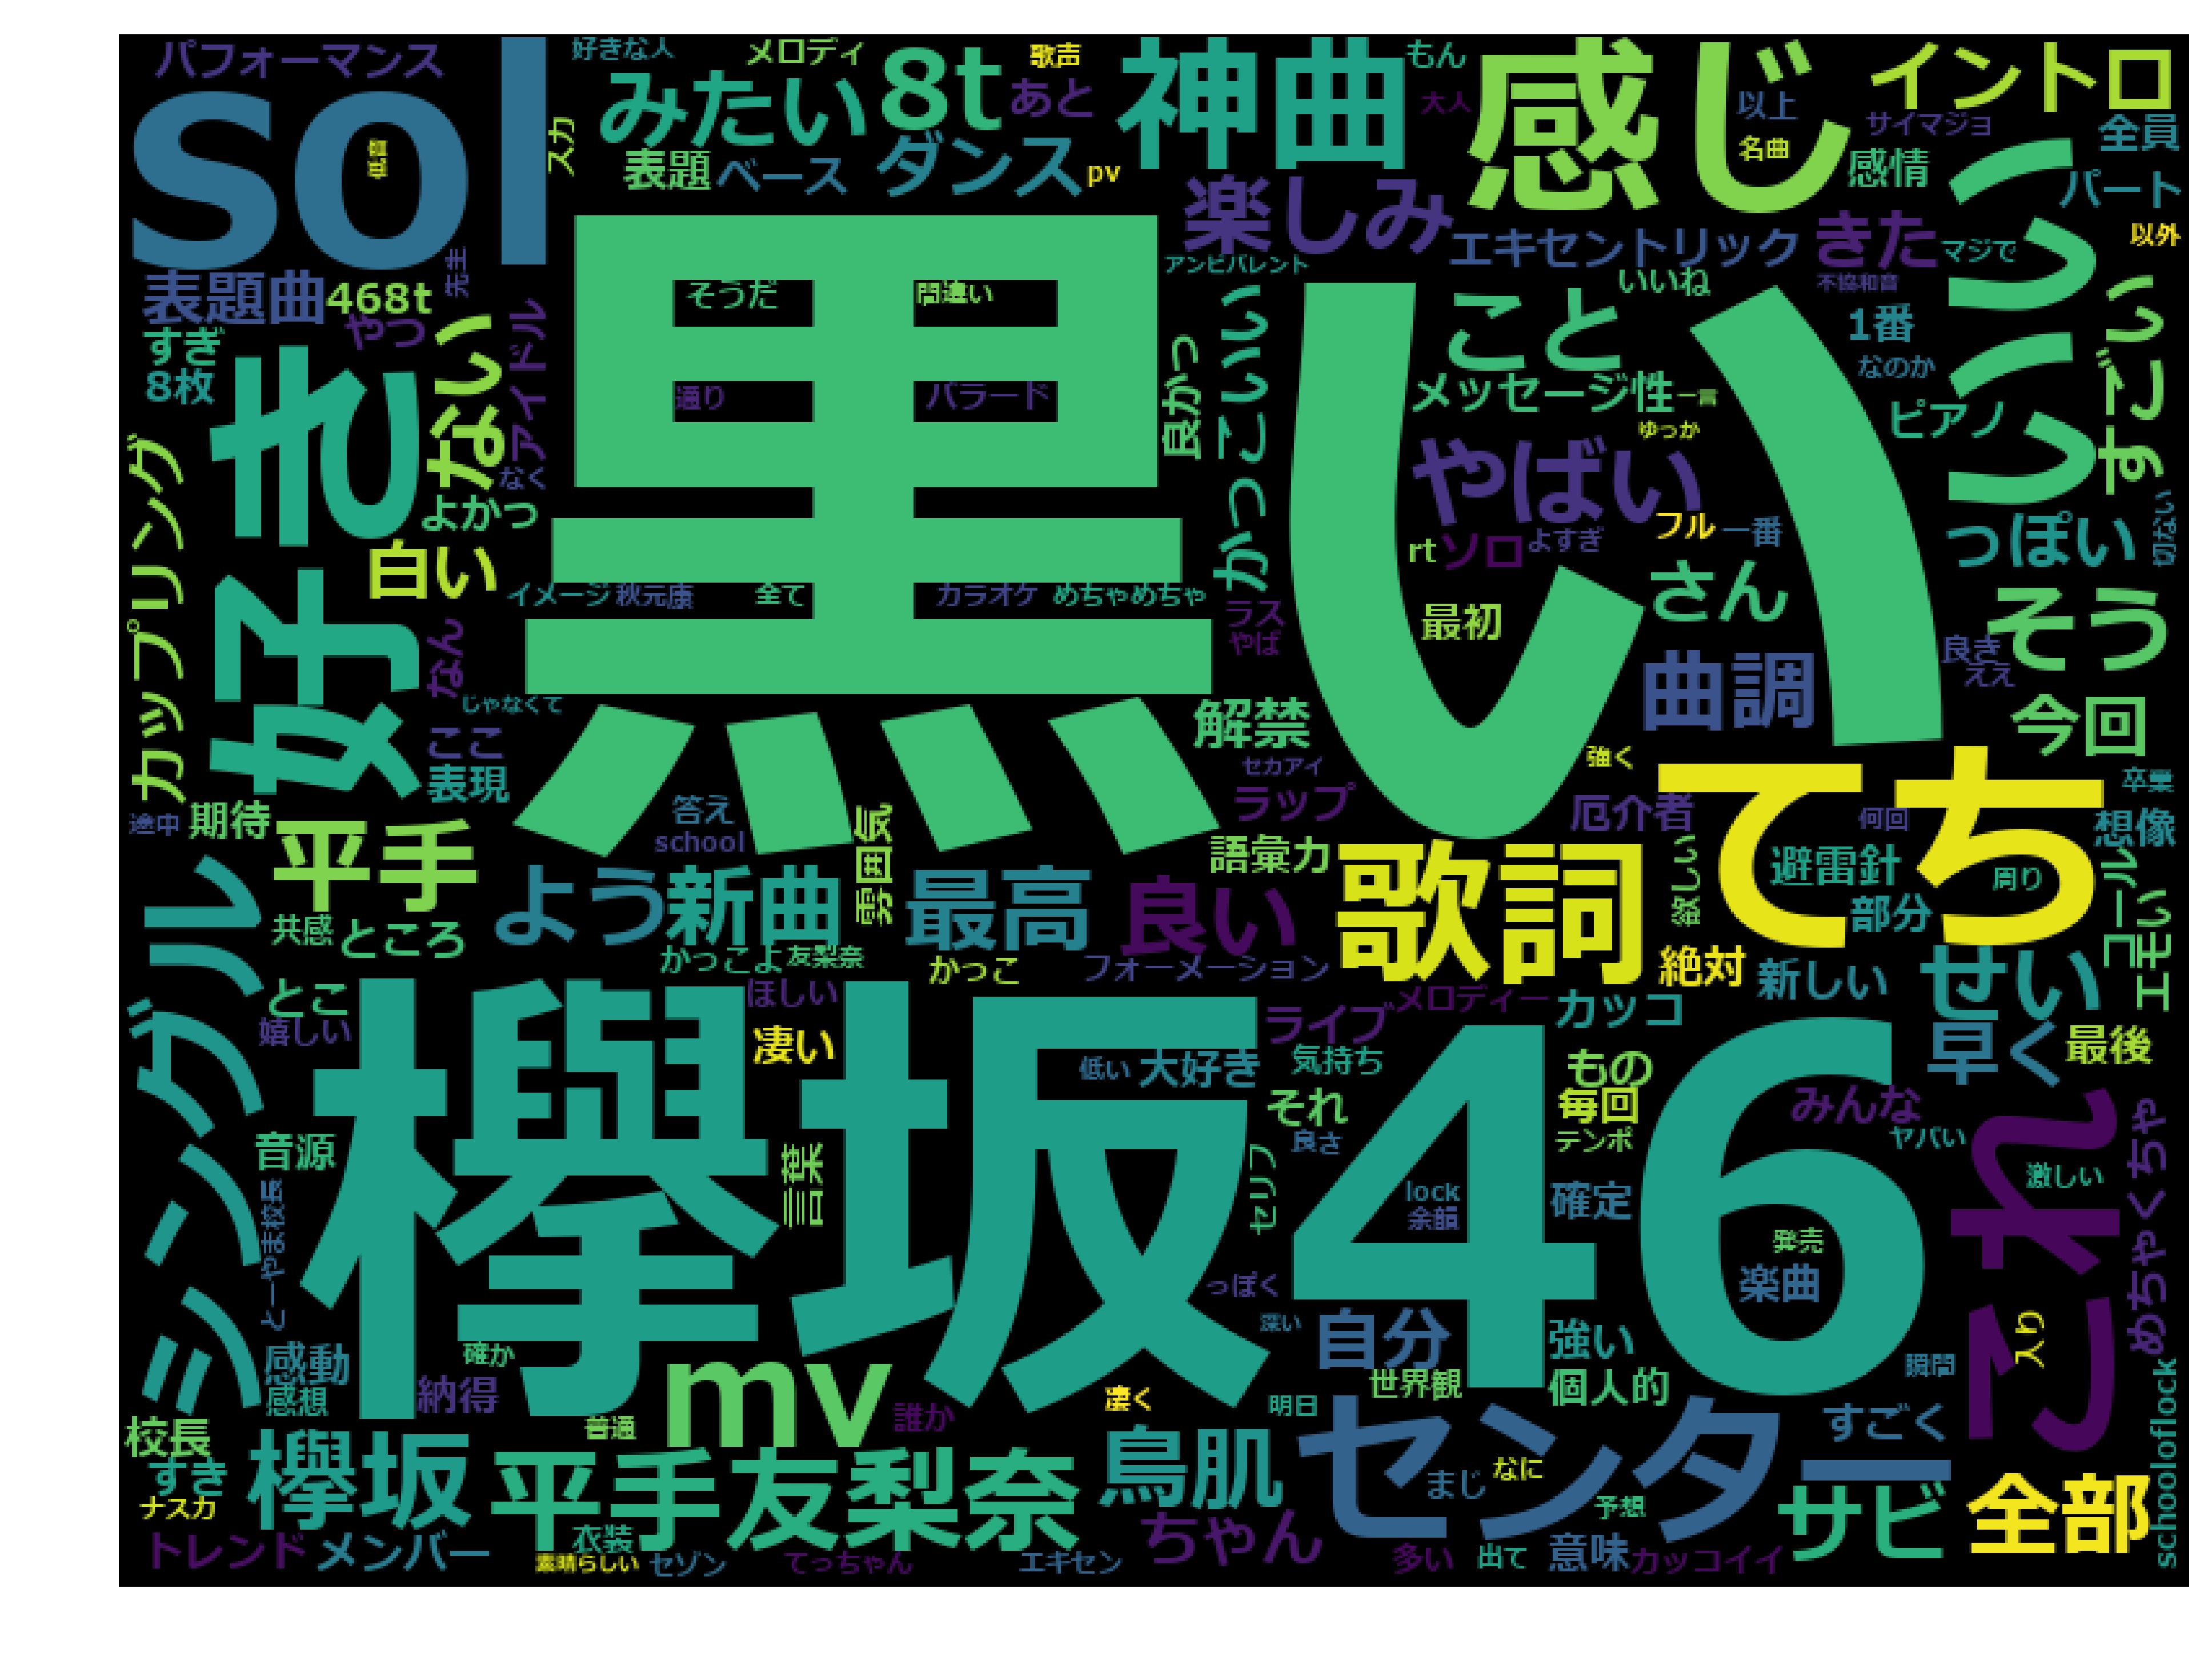

In [85]:
get_wordcrowd(text)

In [84]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from wordcloud import WordCloud
fpath = "C:\Windows\Fonts\meiryob.ttc"

def get_wordcrowd( text ):
    wordcloud = WordCloud(background_color="black",
                          collocations=False,
                          font_path=fpath,
                          width=800,
                          height=600,
                          # stopwords=set(lower_dfs),
                         ).generate( text )

    plt.figure(figsize=(12,9), dpi=200)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()